# STAT 542 / CS 598: Homework 3

Fall 2019, by Edgar Pino

Due: Monday, Oct 7 by 11:59 PM Pacific Time

# Question 1 [50 Points] A Simulation Study


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from basis_expansions import NaturalCubicSpline
from scipy.interpolate import UnivariateSpline

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()

np.random.seed(1)

In [168]:
n = 30

In [169]:
x = np.random.uniform(-1,1,n)

In [170]:
epsilon = np.random.randn(n)

In [171]:
y = np.sin((x * np.pi)) + epsilon

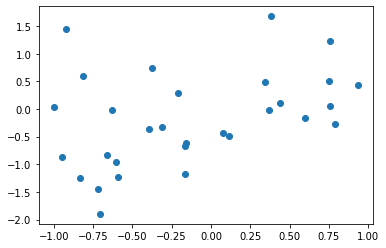

In [172]:
plt.plot(x, y, 'o')
plt.show()

## Write your own code (you cannot use bs() or similar functions) to implement a continuous piecewise linear spline fitting. Choose knots at 

In [48]:
def fit_linear_spline(x, y, knots):
    n_knots = len(knots)
    knots = np.asarray(knots)
    ls = np.zeros((x.shape[0], n_knots + 1))
    ls[:, 0] = x.squeeze()

    for i, knot in enumerate(knots, start=1):
        ls[:, i] = np.maximum(0, x - knot).squeeze()
        
    return LinearRegression().fit(ls, y)

In [49]:
fit_linear_spline(x, y, knots=[-0.5,0,0.5]).coef_

array([ 2.40037633, -3.14405946,  4.6493866 , -7.1960482 ])

## Use existing functions to implement a quadratic spline 2 knots. Choose your own knots.

In [21]:
splines = importr('splines')
r_lm = robjects.r['lm']

In [22]:
unlist = robjects.r['unlist']

In [23]:
unlist(x)

0.327589,0.029778,0.889190,...,0.156779,-0.183726,-0.525946


In [24]:
robjects.globalenv['x'] = unlist(numpy2ri.numpy2rpy(x))
robjects.globalenv['y'] = numpy2ri.numpy2rpy(y)
robjects.globalenv['knots'] = numpy2ri.numpy2rpy(np.array([.5,1]))
robjects.globalenv['bs_val'] = splines.bs(x,df=2)

In [79]:
# r_lm('y ~ bs(x)')

In [ ]:
fit<-lm(wage ~ bs(age,knots = c(0.5,1)),data = Wage )
lm(y ~ bs(x, degree = 2))

## Use existing functions to implement a natural cubic spline with 3 knots. Choose your own knots.

In [77]:
def fit_natural_cubic_spline(x, y,knots):
    ncs = NaturalCubicSpline(knots=knots)
    x_cs = ncs.fit_transform(x)
    
    return LinearRegression().fit(x_cs, y)

In [78]:
fit_natural_cubic_spline(x,y,knots=[-0.5,0.5,1]).coef_

array([ 1.65030288, -0.83456112])

## Use existing functions to implement a smoothing spline. Use the built-in ordinary leave-one-out cross-validation to select the best tuning parameter.


In [129]:
# https://stackoverflow.com/questions/29312005/is-there-a-python-equivalent-to-the-smooth-spline-function-in-r
# import rpy2.robjects as robjects
# r_y = robjects.FloatVector(y_train)
# r_x = robjects.FloatVector(x_train)

# r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
# spline1 = r_smooth_spline(x=r_x, y=r_y, spar=0.7)
# ySpline=np.array(robjects.r['predict'](spline1,robjects.FloatVector(x_smooth)).rx2('y'))
# plt.plot(x_smooth,ySpline)

In [130]:
def smooth_spline(x, y, **args):
    smooth_spline = robjects.r['smooth.spline']
    results = smooth_spline(robjects.FloatVector(x), robjects.FloatVector(y), **args)
    return {"x": np.array(results[0]),"y": np.array(results[1])}

In [131]:
results = smooth_spline(x, y, cv=True)

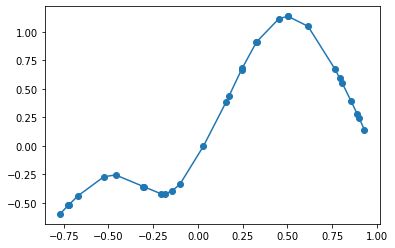

In [132]:
plt.plot(results['x'], results['y'], 'o-')
plt.show()

# Question 2 [50 Points] Multi-dimensional Kernel and Bandwidth Selection

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.nonparametric.kernel_regression import KernelReg

In [62]:
ccpp_data = pd.read_csv('CCPP.csv')

In [63]:
ccpp_data = ccpp_data.apply(pd.to_numeric, errors='coerce')

In [64]:
# mm_scaler = preprocessing.MinMaxScaler()
# ccpp_data = pd.DataFrame(mm_scaler.fit_transform(ccpp_data), columns=ccpp_data.columns)

In [65]:
ccpp_data.head(10)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


In [66]:
ccpp_y = pd.DataFrame(ccpp_data.PE, columns=['PE'])

In [67]:
ccpp_x = ccpp_data.drop(['PE'], axis=1)

## Randomly select 2/3 of the data as training data, and rest as testing. Make sure you set a random seed. You do not need to repeat this process — just fix it and complete the rest of the questions

In [77]:
X_train, X_test, y_train, y_test = train_test_split(ccpp_x, ccpp_y, train_size=2/3, random_state=1)

In [78]:
print(f"{len(X_train)} in train and {len(X_test)} in test")
assert (len(X_train) + len(X_test)) == len(ccpp_data)

31896 in train and 15948 in test


In [79]:
X_train.head(5)

,AT,V,AP,RH
28404,23.64,58.49,1011.40,74.20
15503,20.78,60.84,1018.66,80.40
44568,20.17,56.03,1019.47,56.77
25888,20.88,47.45,1007.50,76.21
33608,25.07,60.27,1018.13,70.33


## Fit the model on the training samples using the kernel estimator and predict on the testing sample. Calculate the prediction error and compare this to a linear model

In [80]:
ksrmv = KernelReg(endog=y_train, exog=[X_train.AT, X_train.V, X_train.AP, X_train.RH], var_type='cccc')

LinAlgError: SVD did not converge

In [46]:
ksrmv

KernelReg instance
Number of variables: k_vars = 4
Number of samples:   N = 47
Variable types:      cccc
BW selection method: cv_ls
Estimator type: ll